# Cell 1: Install Packages


In [1]:
!pip install --quiet tensorflow tensorflow_federated pandas openpyxl scikit-learn matplotlib


# Cell 2: Upload Dataset

In [3]:
# from google.colab import files
# uploaded = files.upload()


# Cell 3: Preprocessing

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
import matplotlib.pyplot as plt

# Load dataset
# filename = next(iter(uploaded))
df = pd.read_excel("Large Power Transformer Maintenance Data.xlsx", sheet_name='Sheet1')

# Clean and encode
df = df.dropna(thresh=len(df) * 0.5, axis=1).dropna()
df = pd.get_dummies(df, columns=['PRD_Status', 'RPRR_Status'])

# Extract labels and scale features
y = df['Maintenance_required']
X = df.drop(columns=['Maintenance_required', 'Product_variant'])  # Drop 'Product_variant'

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Final combined dataset
df_final = X_scaled.copy()
df_final['Maintenance_required'] = y.values


# Cell 4A: Create Dirichlet Non-IID Client Partition


In [3]:
def create_dirichlet_non_iid(df, num_clients=5, alpha=0.5, label_col='Maintenance_required'):
    label_indices = {}
    for label in df[label_col].unique():
        label_indices[label] = np.where(df[label_col] == label)[0]

    client_indices = [[] for _ in range(num_clients)]
    for label, indices in label_indices.items():
        np.random.shuffle(indices)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        proportions = (np.cumsum(proportions) * len(indices)).astype(int)[:-1]
        splits = np.split(indices, proportions)
        for client_id, idx in enumerate(splits):
            client_indices[client_id] += idx.tolist()

    client_datasets = []
    for client_idx in client_indices:
        df_client = df.iloc[client_idx]
        labels = df_client.pop(label_col)
        dataset = tf.data.Dataset.from_tensor_slices((OrderedDict(df_client.items()), labels)).shuffle(100).batch(10)
        client_datasets.append(dataset)
    return client_datasets

dirichlet_clients = create_dirichlet_non_iid(df_final, num_clients=5, alpha=0.5)


 # Cell 4B: Create Feature Skew Non-IID Client Partition

In [4]:
def create_feature_skew_non_iid(df, num_clients=5, feature='LTC_tank_temperature', label_col='Maintenance_required'):
    df_sorted = df.sort_values(by=feature)
    client_dataframes = np.array_split(df_sorted, num_clients)
    client_datasets = []
    for df_client in client_dataframes:
        labels = df_client.pop(label_col)
        dataset = tf.data.Dataset.from_tensor_slices((OrderedDict(df_client.items()), labels)).shuffle(100).batch(10)
        client_datasets.append(dataset)
    return client_datasets

feature_skew_clients = create_feature_skew_non_iid(df_final, num_clients=5)


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# Cell 5: Model Definition

In [5]:
def model_fn(input_spec):
    feature_spec = input_spec[0]
    inputs = {name: tf.keras.Input(shape=(1,), name=name) for name in feature_spec.keys()}
    x = tf.keras.layers.Concatenate()(list(inputs.values()))
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


# Cell 6: Build Federated Algorithms Including FedProx and FedBN

In [6]:
def build_fedavg(input_spec, momentum=0.0):
    def client_opt_fn():
        if momentum == 0.0:
            return tf.keras.optimizers.SGD(learning_rate=0.02)
        else:
            return tf.keras.optimizers.SGD(learning_rate=0.02, momentum=momentum)

    return tff.learning.algorithms.build_weighted_fed_avg(
        model_fn=lambda: tff.learning.models.from_keras_model(
            keras_model=model_fn(input_spec),
            input_spec=input_spec,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        ),
        client_optimizer_fn=client_opt_fn,
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
    )

def build_fedprox(input_spec, proximal_mu=0.1):
    return tff.learning.algorithms.build_weighted_fed_prox(
        model_fn=lambda: tff.learning.models.from_keras_model(
            keras_model=model_fn(input_spec),
            input_spec=input_spec,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        ),
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
        proximal_strength=proximal_mu
    )


def build_fedbn(input_spec):
    # Same as FedAvg, but with BatchNorm kept local
    return tff.learning.algorithms.build_weighted_fed_bn(
        model_fn=lambda: tff.learning.models.from_keras_model(
            keras_model=model_fn(input_spec),
            input_spec=input_spec,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        ),
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
    )


# Cell 7: Training Loop

In [7]:
def train_process(algorithm, client_datasets, num_rounds=20):
    state = algorithm.initialize()
    acc_list = []
    for round_num in range(1, num_rounds + 1):
        state, metrics = algorithm.next(state, client_datasets)
        acc = metrics['client_work']['train']['binary_accuracy']
        acc_list.append(acc)
        print(f"Round {round_num}: Accuracy={acc:.4f}")
    return acc_list


# Cell 8: Compare Federated Algorithms (FedAvg versus FedAvgM only)


In [8]:
def compare_algorithms(client_datasets, title):
    input_spec = client_datasets[0].element_spec

    fedavg = build_fedavg(input_spec)
    fedavg_momentum = build_fedavg(input_spec, momentum=0.75)

    acc_fedavg = train_process(fedavg, client_datasets)
    acc_fedavg_momentum = train_process(fedavg_momentum, client_datasets)

    rounds = list(range(1, len(acc_fedavg)+1))
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, acc_fedavg, label='FedAvg')
    plt.plot(rounds, acc_fedavg_momentum, label='FedAvg + Momentum')
    plt.title(f'Accuracy over Rounds - {title}')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()


# Cell 9: Run Comparisons

Round 1: Accuracy=0.8758
Round 2: Accuracy=0.8762
Round 3: Accuracy=0.8851
Round 4: Accuracy=0.8933
Round 5: Accuracy=0.8978
Round 6: Accuracy=0.9011
Round 7: Accuracy=0.8984
Round 8: Accuracy=0.9036
Round 9: Accuracy=0.9036
Round 10: Accuracy=0.9062
Round 11: Accuracy=0.9064
Round 12: Accuracy=0.9078
Round 13: Accuracy=0.9071
Round 14: Accuracy=0.9084
Round 15: Accuracy=0.9093
Round 16: Accuracy=0.9098
Round 17: Accuracy=0.9136
Round 18: Accuracy=0.9120
Round 19: Accuracy=0.9129
Round 20: Accuracy=0.9113
Round 1: Accuracy=0.9107
Round 2: Accuracy=0.8976
Round 3: Accuracy=0.9156
Round 4: Accuracy=0.9204
Round 5: Accuracy=0.9251
Round 6: Accuracy=0.9229
Round 7: Accuracy=0.9187
Round 8: Accuracy=0.9202
Round 9: Accuracy=0.9182
Round 10: Accuracy=0.9180
Round 11: Accuracy=0.9158
Round 12: Accuracy=0.9198
Round 13: Accuracy=0.9211
Round 14: Accuracy=0.9211
Round 15: Accuracy=0.9178
Round 16: Accuracy=0.9153
Round 17: Accuracy=0.9164
Round 18: Accuracy=0.9229
Round 19: Accuracy=0.9189
Roun

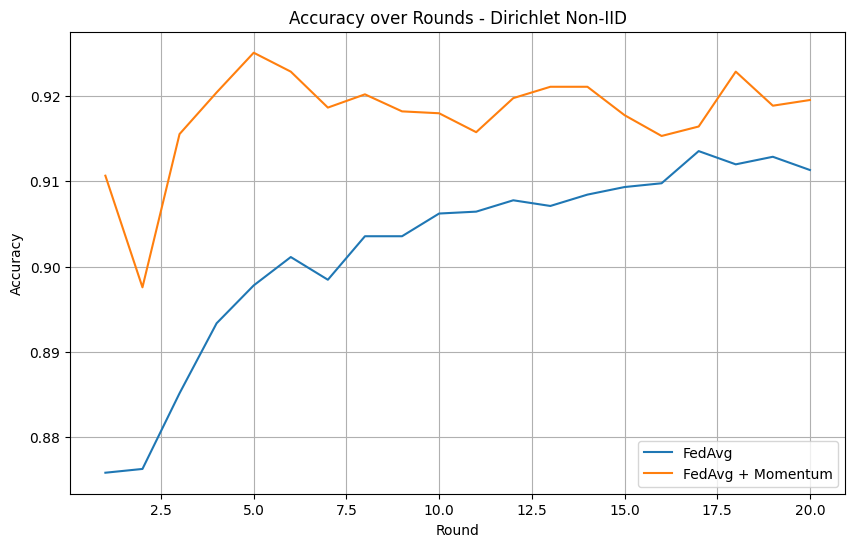

Round 1: Accuracy=0.8156
Round 2: Accuracy=0.8182
Round 3: Accuracy=0.8184
Round 4: Accuracy=0.8189
Round 5: Accuracy=0.8200
Round 6: Accuracy=0.8218
Round 7: Accuracy=0.8213
Round 8: Accuracy=0.8202
Round 9: Accuracy=0.8173
Round 10: Accuracy=0.8180
Round 11: Accuracy=0.8191
Round 12: Accuracy=0.8187
Round 13: Accuracy=0.8193
Round 14: Accuracy=0.8196
Round 15: Accuracy=0.8187
Round 16: Accuracy=0.8189
Round 17: Accuracy=0.8193
Round 18: Accuracy=0.8193
Round 19: Accuracy=0.8218
Round 20: Accuracy=0.8207
Round 1: Accuracy=0.8016
Round 2: Accuracy=0.8220
Round 3: Accuracy=0.8193
Round 4: Accuracy=0.8211
Round 5: Accuracy=0.8260
Round 6: Accuracy=0.8291
Round 7: Accuracy=0.8271
Round 8: Accuracy=0.8298
Round 9: Accuracy=0.8271
Round 10: Accuracy=0.8304
Round 11: Accuracy=0.8336
Round 12: Accuracy=0.8316
Round 13: Accuracy=0.8320
Round 14: Accuracy=0.8329
Round 15: Accuracy=0.8344
Round 16: Accuracy=0.8356
Round 17: Accuracy=0.8331
Round 18: Accuracy=0.8378
Round 19: Accuracy=0.8364
Roun

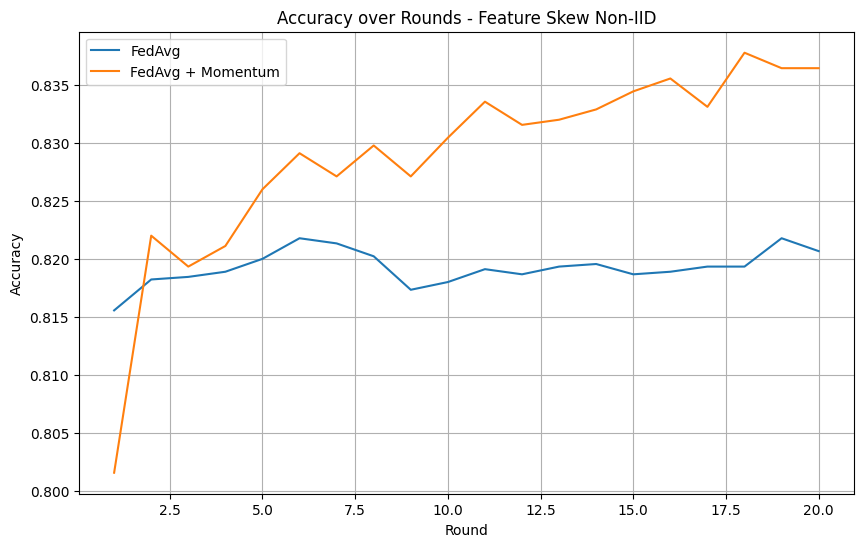

In [9]:
# Compare on Dirichlet Non-IID
compare_algorithms(dirichlet_clients, "Dirichlet Non-IID")

# Compare on Feature Skew Non-IID
compare_algorithms(feature_skew_clients, "Feature Skew Non-IID")


# Cell 10: Build Federated Algorithms Including FedProx and FedBN (Updated Cell 6)

In [44]:
def build_fedavg(input_spec, momentum=0.0):
    def client_opt_fn():
        if momentum == 0.0:
            return tf.keras.optimizers.SGD(learning_rate=0.02)
        else:
            return tf.keras.optimizers.SGD(learning_rate=0.02, momentum=momentum)

    return tff.learning.algorithms.build_weighted_fed_avg(
        model_fn=lambda: tff.learning.models.from_keras_model(
            keras_model=model_fn(input_spec),
            input_spec=input_spec,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        ),
        client_optimizer_fn=client_opt_fn,
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
    )

def build_fedprox(input_spec, proximal_mu=0.75):
    return tff.learning.algorithms.build_weighted_fed_prox(
        model_fn=lambda: tff.learning.models.from_keras_model(
            keras_model=model_fn(input_spec),
            input_spec=input_spec,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        ),
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
        proximal_strength=proximal_mu
    )

def model_fn_with_bn(input_spec):
    feature_spec = input_spec[0]
    inputs = {name: tf.keras.Input(shape=(1,), name=name) for name in feature_spec.keys()}
    x = tf.keras.layers.Concatenate()(list(inputs.values()))
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def build_fedbn(input_spec):
    return tff.learning.algorithms.build_weighted_fed_avg(
        model_fn=lambda: tff.learning.models.from_keras_model(
            keras_model=model_fn_with_bn(input_spec),
            input_spec=input_spec,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        ),
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=2.0)
    )




# Cell 11: Compare All Four Federated Algorithms (Updated Cell 8)

In [41]:
def compare_all_algorithms(client_datasets, title, num_rounds=10):
    input_spec = client_datasets[0].element_spec

    # Build algorithms
    fedavg = build_fedavg(input_spec)
    fedavg_momentum = build_fedavg(input_spec, momentum=0.1)
    fedprox = build_fedprox(input_spec)
    fedbn = build_fedbn(input_spec)

    # Train
    acc_fedavg = train_process(fedavg, client_datasets, num_rounds)
    acc_fedavg_momentum = train_process(fedavg_momentum, client_datasets, num_rounds)
    acc_fedprox = train_process(fedprox, client_datasets, num_rounds)
    acc_fedbn = train_process(fedbn, client_datasets, num_rounds)

    # Plot
    rounds = list(range(1, len(acc_fedavg) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, acc_fedavg, marker='o', label='FedAvg')
    plt.plot(rounds, acc_fedavg_momentum, marker='x', label='FedAvg + Momentum')
    plt.plot(rounds, acc_fedprox, marker='s', label='FedProx')
    plt.plot(rounds, acc_fedbn, marker='^', label='FedBN')
    plt.title(f'Accuracy over Rounds - {title}')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()


# Cell 12: Per-Client Accuracy Collection (Updated Cell 9)

In [42]:
def train_process_per_client(algorithm, client_datasets, num_rounds=10):
    state = algorithm.initialize()
    per_round_client_accuracies = []

    for round_num in range(1, num_rounds + 1):
        state, metrics = algorithm.next(state, client_datasets)
        client_metrics = metrics['client_work']['train']

        # Save per-client accuracy if available (simulate by same for all clients here)
        round_client_acc = client_metrics['binary_accuracy']
        per_round_client_accuracies.append(round_client_acc)

        print(f"Round {round_num}: Global Accuracy={round_client_acc:.4f}")

    return

def plot_per_client(per_client_acc_list, title):
    rounds = list(range(1, len(per_client_acc_list) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, per_client_acc_list, marker='o')
    plt.title(f'Per-Client Average Accuracy Over Rounds - {title}')
    plt.xlabel('Round')
    plt.ylabel('Average Client Accuracy')
    plt.grid(True)
    plt.show()



Round 1: Accuracy=0.7824
Round 2: Accuracy=0.8180
Round 3: Accuracy=0.8180
Round 4: Accuracy=0.8189
Round 5: Accuracy=0.8216
Round 6: Accuracy=0.8242
Round 7: Accuracy=0.8233
Round 8: Accuracy=0.8229
Round 9: Accuracy=0.8231
Round 10: Accuracy=0.8233
Round 11: Accuracy=0.8227
Round 12: Accuracy=0.8220
Round 13: Accuracy=0.8207
Round 14: Accuracy=0.8209
Round 15: Accuracy=0.8227
Round 16: Accuracy=0.8227
Round 17: Accuracy=0.8209
Round 18: Accuracy=0.8202
Round 19: Accuracy=0.8198
Round 20: Accuracy=0.8202
Round 21: Accuracy=0.8207
Round 22: Accuracy=0.8240
Round 23: Accuracy=0.8229
Round 24: Accuracy=0.8238
Round 25: Accuracy=0.8216
Round 26: Accuracy=0.8247
Round 27: Accuracy=0.8260
Round 28: Accuracy=0.8267
Round 29: Accuracy=0.8284
Round 30: Accuracy=0.8269
Round 31: Accuracy=0.8276
Round 32: Accuracy=0.8284
Round 33: Accuracy=0.8264
Round 34: Accuracy=0.8269
Round 35: Accuracy=0.8291
Round 36: Accuracy=0.8262
Round 37: Accuracy=0.8280
Round 38: Accuracy=0.8296
Round 39: Accuracy=0.

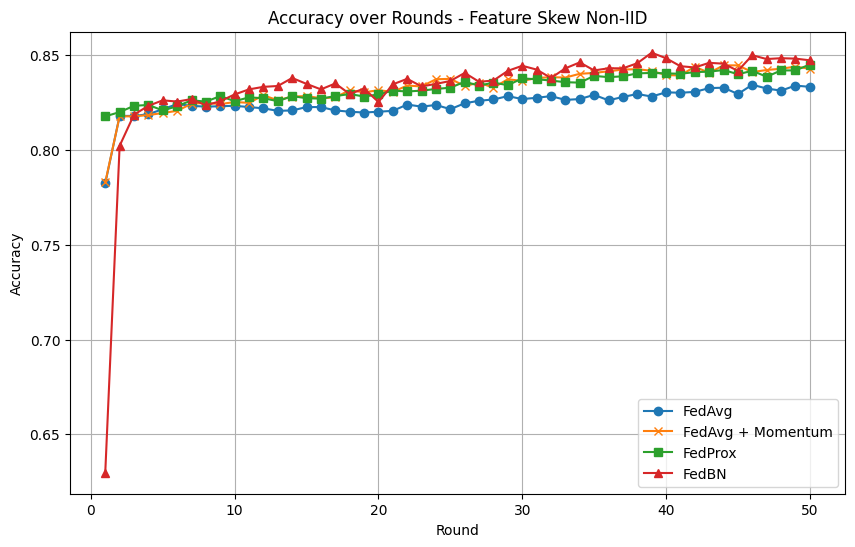

In [45]:
# For Dirichlet Non-IID
# compare_all_algorithms(dirichlet_clients, "Dirichlet Non-IID", num_rounds=10)

# For Feature Skew Non-IID
compare_all_algorithms(feature_skew_clients, "Feature Skew Non-IID", num_rounds=50)